<a href="https://www.kaggle.com/code/fotimakhongulomova/neural-network-classification?scriptVersionId=188091934" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Neural Network Classification with Pytorch

Classification is a problem of predicting whether something is one thing or another (there can be nultiple things as the options).

## 1. Make classification data and get it ready

In [1]:
import sklearn 
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import make_circles

torch.__version__

'2.1.2'

In [2]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [5]:
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "labels": y})
circles.head()

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


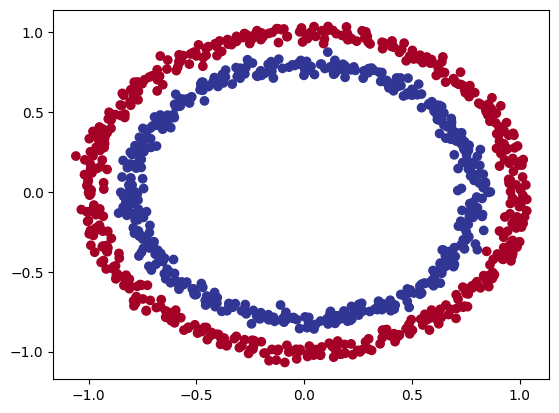

In [6]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

### 1.2 Turn data into tensors and create train and test splits

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [12]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [14]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonistic code so our code will run on an acclerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [15]:
# Make device agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

### Model:
1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target `device`

In [17]:
from sklearn import datasets

# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layesrs capable of hadling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6644, -0.5853],
                      [ 0.1416, -0.3534],
                      [ 0.0504,  0.1469],
                      [-0.4881, -0.3712],
                      [ 0.3690, -0.0806]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.3622,  0.5130, -0.1492,  0.2636,  0.1266], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1657, -0.2299,  0.4136, -0.3697, -0.1120]], device='cuda:0')),
             ('1.bias', tensor([0.4460], device='cuda:0'))])

In [20]:
# Make predictions 
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[0.3388],
        [0.3986],
        [0.1424],
        [0.3947],
        [0.0795],
        [0.1165],
        [0.3348],
        [0.2685],
        [0.1454],
        [0.4020]], device='cuda:0')

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

In [21]:
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function buil-in
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [22]:
# Calculate accuracy 
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train a model

1. Forward pass
2. Calculate the loss
3. Optimer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

In [23]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
    
y_logits

tensor([[0.3388],
        [0.3986],
        [0.1424],
        [0.3947],
        [0.0795]], device='cuda:0')

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
# Use sigmoid activation function on our model
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5839],
        [0.5984],
        [0.5355],
        [0.5974],
        [0.5199]], device='cuda:0')

In [26]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_probs.squeeze()))
y_preds.squeeze()

tensor([False, False, False, False, False], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## 3.2 Building a training and testing loop

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (backpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test Loss: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69953, Acc: 50.00% | Test loss: 0.70523, Test Loss: 50.00%
Epoch: 10 | Loss: 0.69637, Acc: 55.00% | Test loss: 0.70236, Test Loss: 52.50%
Epoch: 20 | Loss: 0.69506, Acc: 53.00% | Test loss: 0.70095, Test Loss: 48.50%
Epoch: 30 | Loss: 0.69445, Acc: 51.88% | Test loss: 0.70009, Test Loss: 49.00%
Epoch: 40 | Loss: 0.69412, Acc: 51.75% | Test loss: 0.69945, Test Loss: 49.00%
Epoch: 50 | Loss: 0.69391, Acc: 52.25% | Test loss: 0.69893, Test Loss: 47.00%
Epoch: 60 | Loss: 0.69376, Acc: 51.62% | Test loss: 0.69848, Test Loss: 47.00%
Epoch: 70 | Loss: 0.69364, Acc: 51.62% | Test loss: 0.69809, Test Loss: 47.50%
Epoch: 80 | Loss: 0.69354, Acc: 51.75% | Test loss: 0.69774, Test Loss: 47.50%
Epoch: 90 | Loss: 0.69347, Acc: 51.62% | Test loss: 0.69744, Test Loss: 48.00%


## 4. Make predictions and evaluate the model

In [29]:
import requests
from pathlib import Path

# Dowland helper functions from Learn Pytorch repo 

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")

else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


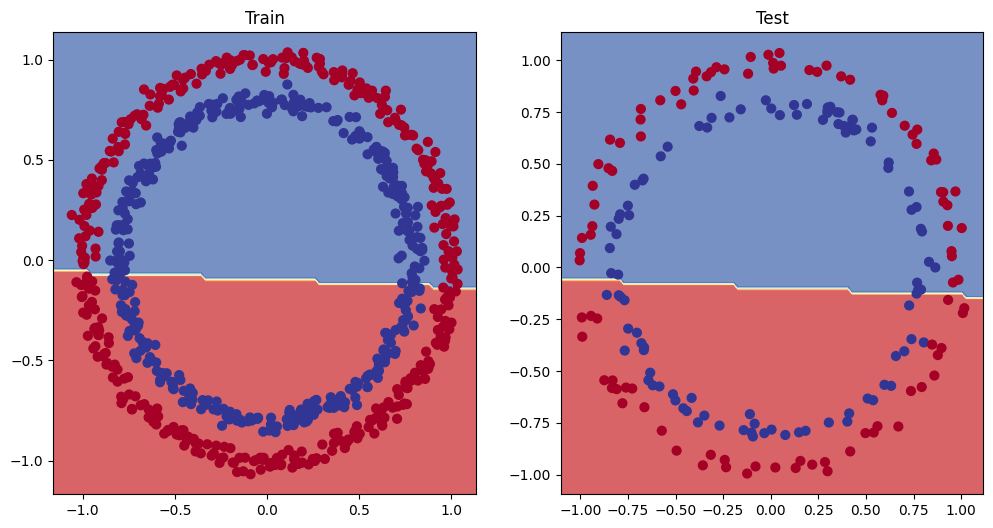

In [30]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers 
* Add more hidden units
* Fit for longer
* Change the activation functions
* Change the learning rate
* Change the loss function

In [31]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6624, -0.6059],
                      [ 0.1386, -0.3214],
                      [ 0.0552,  0.0947],
                      [-0.4924, -0.3247],
                      [ 0.3676, -0.0659]])),
             ('0.bias', tensor([ 0.3404,  0.5468, -0.2056,  0.3141,  0.1423])),
             ('1.weight',
              tensor([[ 0.1845, -0.2575,  0.4230, -0.3710, -0.1168]])),
             ('1.bias', tensor([0.3117]))])

In [32]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layesrs capable of hadling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.relu(self.layer_1(x)))))) # x -> layer_1 -> layer_2 -> output
    
# 4. Instantiate an instance of our model class and send it to the target device
model_1 = CircleModelV2().to(device)
model_1

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function buil-in
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (backpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test Loss: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69203, Test Loss: 55.50%
Epoch: 10 | Loss: 0.68651, Acc: 53.00% | Test loss: 0.68401, Test Loss: 56.50%
Epoch: 20 | Loss: 0.67698, Acc: 53.50% | Test loss: 0.67149, Test Loss: 57.00%
Epoch: 30 | Loss: 0.66078, Acc: 60.75% | Test loss: 0.65295, Test Loss: 62.00%
Epoch: 40 | Loss: 0.63241, Acc: 66.88% | Test loss: 0.62340, Test Loss: 70.00%
Epoch: 50 | Loss: 0.58509, Acc: 74.25% | Test loss: 0.57695, Test Loss: 76.50%
Epoch: 60 | Loss: 0.52041, Acc: 81.50% | Test loss: 0.52935, Test Loss: 81.00%
Epoch: 70 | Loss: 0.43584, Acc: 90.75% | Test loss: 0.45495, Test Loss: 89.00%
Epoch: 80 | Loss: 0.33954, Acc: 96.50% | Test loss: 0.35861, Test Loss: 95.50%
Epoch: 90 | Loss: 0.24768, Acc: 98.50% | Test loss: 0.27244, Test Loss: 97.00%


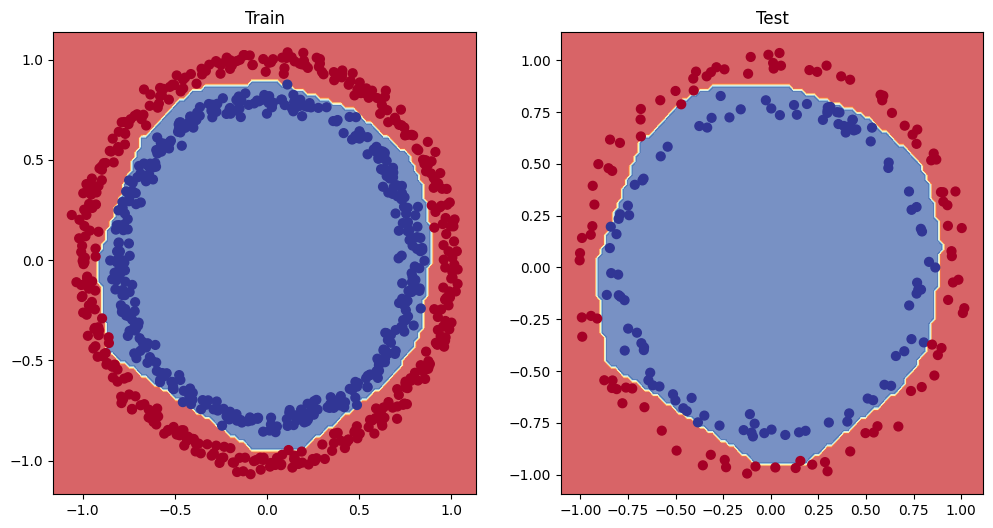

In [34]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# 8. Putting it all together with a multi-class classification problem

## 8.1 Creating a toy multi-class dataset

In [35]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [36]:
# Set the hyperparameters for data creation 
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

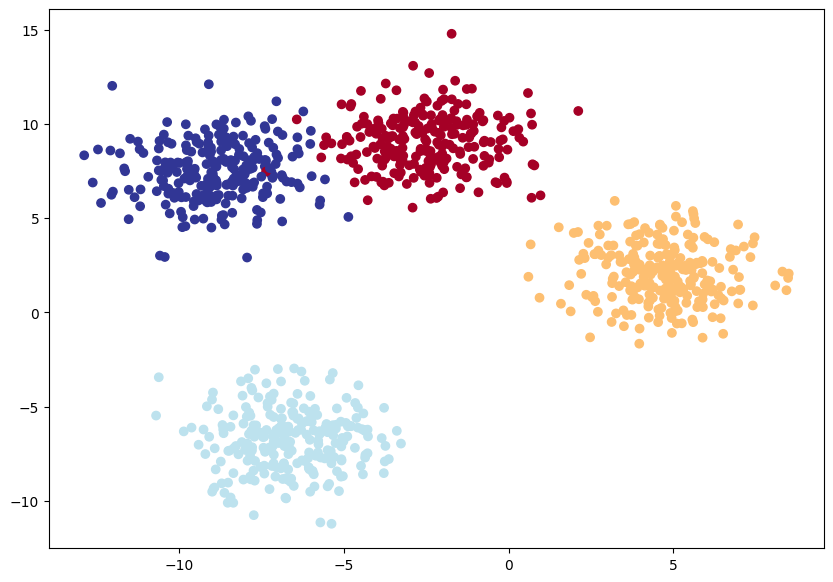

In [37]:
# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES,
                           cluster_std=1.5, random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, 
                                                                        test_size=0.2, random_state=RANDOM_SEED)

# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

## 8.2 Building a multi-class classification model in Pytorch

In [38]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [39]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification model.
        
        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 8.3 Create a loss function and an optimizer for a multi-class classification model

In [40]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

## 8.4 Getting prdiction probabilities for a multi-class Pytorch model

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [41]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
    
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [42]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [43]:
# Convert out model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [44]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [45]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

## 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [46]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
    ### Training
    model_4.train()
    
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
        
    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test Loss: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test loss: 1.07554, Test Loss: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test loss: 0.66069, Test Loss: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test loss: 0.43074, Test Loss: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test loss: 0.24508, Test Loss: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test loss: 0.10229, Test Loss: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test loss: 0.05848, Test Loss: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test loss: 0.04293, Test Loss: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test loss: 0.03491, Test Loss: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test loss: 0.02988, Test Loss: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test loss: 0.02663, Test Loss: 99.50%


## 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [47]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    
# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [48]:
y_pred_logits = torch.softmax(y_logits, dim=1)
y_pred_logits[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [49]:
y_preds = torch.argmax(y_pred_logits, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [50]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

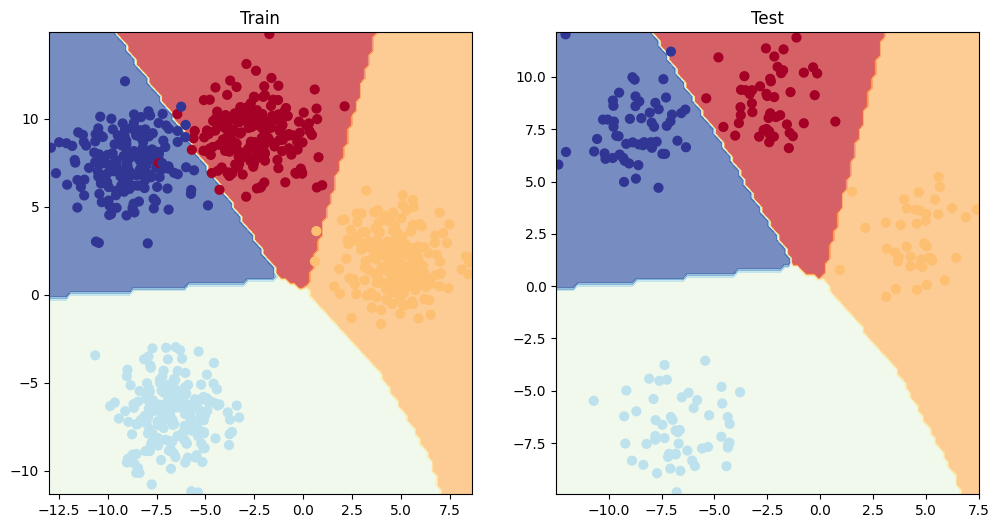

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# 9. A few more classification metrics... (to evaluate our classification model)

In [52]:
!pip install torchmetrics

In [53]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [54]:
# 14:00:20